# colab setting, read file and import module

In [ ]:
#!pip install google.colab #如未安裝取消註解後執行
import os
from google.colab import drive
drive.mount('/content/my_drive')

Mounted at /content/my_drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
file_path = '/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/xgboost_month_freq_dataset.csv'
df = pd.read_csv(file_path)

In [ ]:
df.info(max_cols=149)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806578 entries, 0 to 806577
Data columns (total 149 columns):
 #    Column                         Non-Null Count   Dtype  
---   ------                         --------------   -----  
 0    usage_category                 781214 non-null  object 
 1    address                        806578 non-null  object 
 2    property_type                  806566 non-null  object 
 3    community_name                 543379 non-null  object 
 4    main_building_ratio            750580 non-null  float64
 5    city                           806578 non-null  object 
 6    parking_space_price            190741 non-null  float64
 7    transaction_date               806578 non-null  object 
 8    elevator_available             288775 non-null  float64
 9    building_age                   611128 non-null  float64
 10   number_of_land                 806578 non-null  int64  
 11   number_of_building             806578 non-null  int64  
 12   number_of_park

# 離群值濾除
* 邏輯上應該是要先濾除outlier再補值(至少補mean要這樣做)

In [ ]:
df_clean = df.copy()

In [ ]:
df_clean['property_type'].unique()

array(['公寓(5樓含以下無電梯)', '華廈(10層含以下有電梯)', '套房(1房(1廳)1衛)', '住宅大樓(11層含以上有電梯)',
       '店面（店舖)', '透天厝', '辦公商業大樓', '農舍', '廠辦', '其他', '工廠', '倉庫', nan],
      dtype=object)

In [ ]:
df_clean['total_area_ping'].describe()

count    806578.000000
mean         42.743463
std          94.039980
min           0.000000
25%          24.610000
50%          34.430000
75%          49.260000
max       29216.550000
Name: total_area_ping, dtype: float64

## 非居住用途

In [ ]:
non_live_df = df_clean[ (df_clean['property_type'] == '辦公商業大樓') | (df_clean['property_type'] == '農舍') | (df_clean['property_type'] == '廠辦') | (df_clean['property_type'] == '工廠') | (df_clean['property_type'] == '倉庫') ]

In [ ]:
len(non_live_df)

15493

In [ ]:
non_live_df['total_area_ping'].describe()

count    15493.000000
mean       147.307814
std        489.700204
min          0.020000
25%         42.130000
50%         83.800000
75%        129.680000
max      29216.550000
Name: total_area_ping, dtype: float64

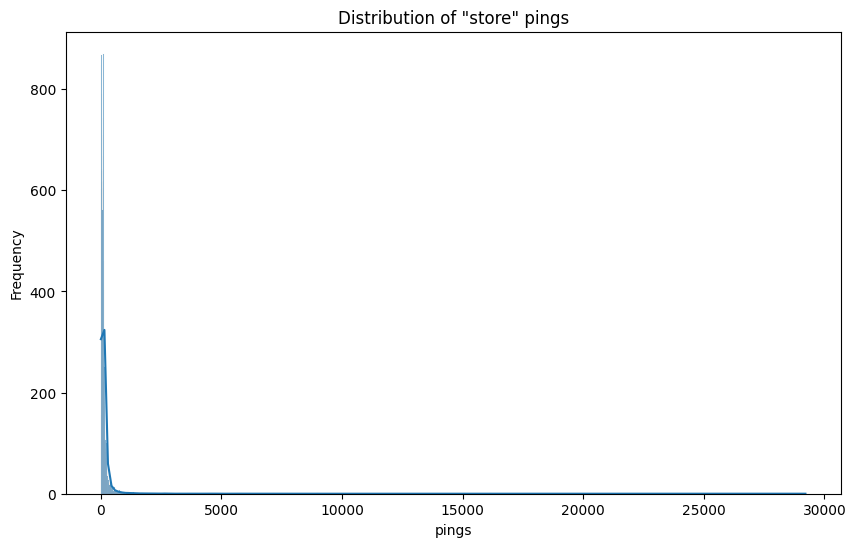

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(non_live_df['total_area_ping'], kde=True)
plt.xlabel('pings')
plt.ylabel('Frequency')
plt.title('Distribution of "store" pings')
plt.show()

## 店面(暫留)，但先把離群職處理一下
* 因分布比較像，且住商混和

In [ ]:
store_df = df_clean[df_clean['property_type'] == '店面（店舖)']

In [ ]:
len(store_df)

8637

In [ ]:
store_df['total_area_ping'].describe()

count    8637.000000
mean       41.256347
std        47.417278
min         0.010000
25%        22.670000
50%        31.550000
75%        47.990000
max      1723.690000
Name: total_area_ping, dtype: float64

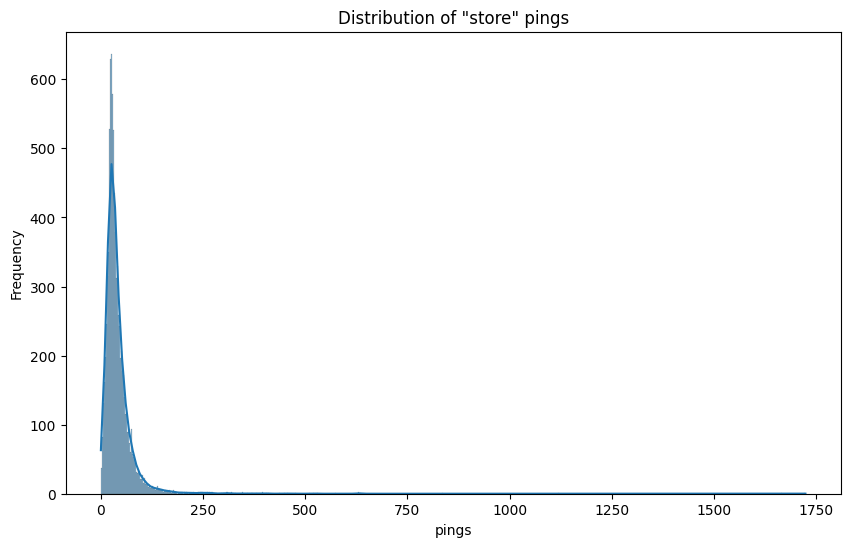

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(store_df['total_area_ping'], kde=True)
plt.xlabel('pings')
plt.ylabel('Frequency')
plt.title('Distribution of "store" pings')
plt.show()

In [ ]:
store_IQR = store_df['total_area_ping'].quantile(0.75) - store_df['total_area_ping'].quantile(0.25)
loose_store_max = store_df['total_area_ping'].quantile(0.75) + (1.5*store_IQR)
strict_store_max = store_df['total_area_ping'].quantile(0.75) + (3*store_IQR)

In [ ]:
len(store_df[ store_df['total_area_ping'] > strict_store_max])

215

In [ ]:
len(store_df[ store_df['total_area_ping'] < loose_store_max])

8109

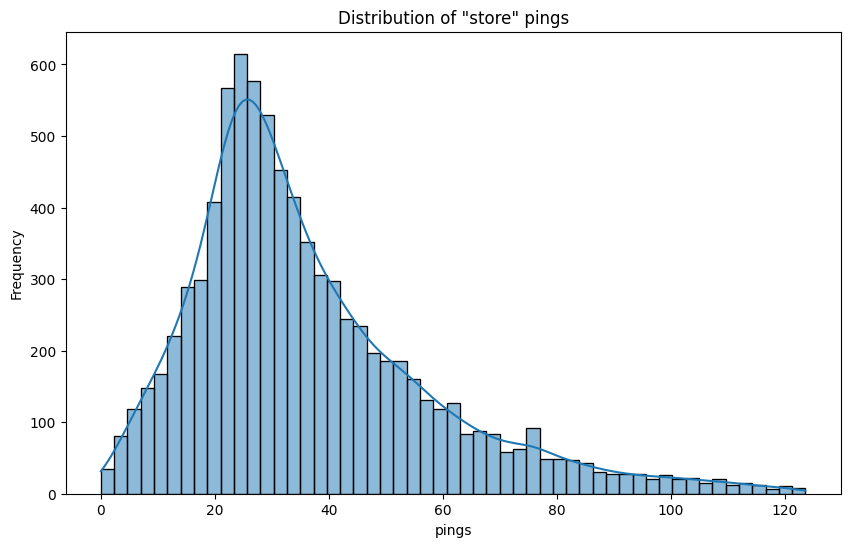

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(store_df[ store_df['total_area_ping'] < strict_store_max]['total_area_ping'] , kde=True)
plt.xlabel('pings')
plt.ylabel('Frequency')
plt.title('Distribution of "store" pings')
plt.show()

## property_type = '其他'

In [ ]:
othr_df = df_clean[ (df_clean['property_type'] == '其他') ]  # (df_clean['property_type'].isnull())的範圍算是正常  # "其他"的範圍非常爆炸(共3736筆)

In [ ]:
len(othr_df)

3736

In [ ]:
othr_df['total_area_ping'].describe()

count     3736.000000
mean        77.732230
std        407.137014
min          0.460000
25%         28.077500
50%         42.195000
75%         71.572500
max      20910.470000
Name: total_area_ping, dtype: float64

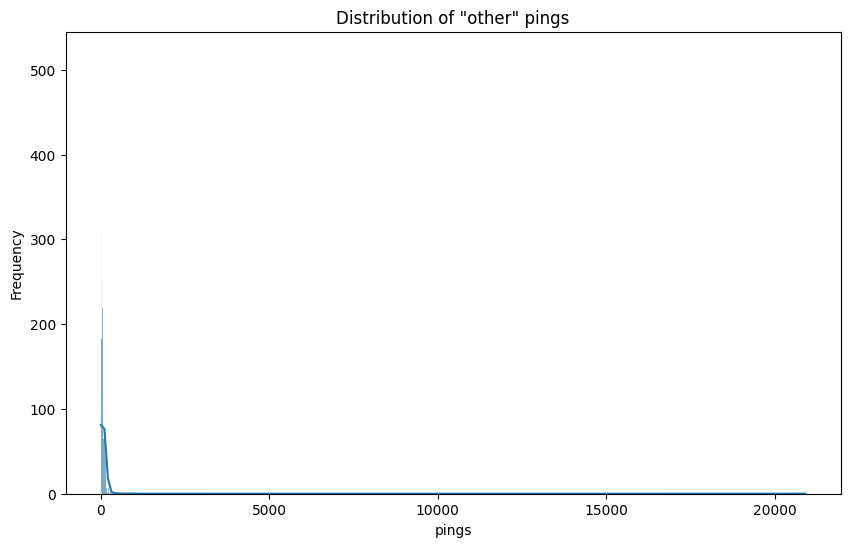

In [ ]:
# 劃出原先的分布圖
plt.figure(figsize=(10, 6))
sns.histplot(othr_df['total_area_ping'], kde=True)
plt.xlabel('pings')
plt.ylabel('Frequency')
plt.title('Distribution of "other" pings')
plt.show()

In [ ]:
# 四分位距法
# 對於property_type = '其他' ，採用1.5IQR(較寬鬆的離群值標準，去除更多的值)作為離群值標準
other_IQR = othr_df['total_area_ping'].quantile(0.75) - othr_df['total_area_ping'].quantile(0.25)
other_loose_min = othr_df['total_area_ping'].quantile(0.25) - (1.5*other_IQR) # 這可能要想一下怎麼丟，因為1.5IQR就是負的了
other_loose_max = othr_df['total_area_ping'].quantile(0.75) + (1.5*other_IQR)

In [ ]:
othr_df[ othr_df['total_area_ping'] < other_loose_max ]['total_area_ping'].describe()

count    3535.000000
mean       48.446996
std        30.602959
min         0.460000
25%        26.990000
50%        40.020000
75%        67.930000
max       136.640000
Name: total_area_ping, dtype: float64

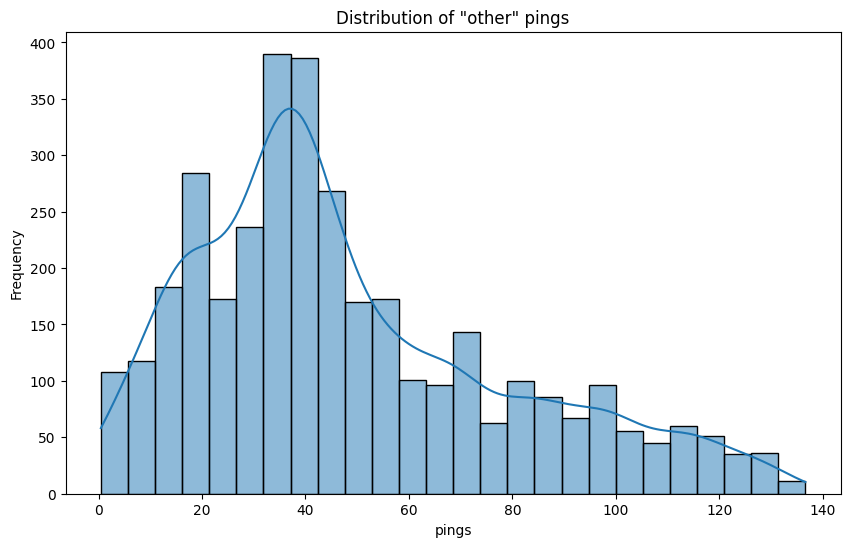

In [ ]:
# 濾除離群值後的分佈
plt.figure(figsize=(10, 6))
sns.histplot(othr_df[ othr_df['total_area_ping'] < other_loose_max ]['total_area_ping'], kde=True)
plt.xlabel('pings')
plt.ylabel('Frequency')
plt.title('Distribution of "other" pings')
plt.show()

## property_type is null

In [ ]:
null_df = df_clean[df_clean['property_type'].isnull()]

In [ ]:
len(null_df)

12

In [ ]:
null_df['total_area_ping'].describe()

count     12.000000
mean      58.156667
std       21.576830
min       30.530000
25%       48.640000
50%       56.500000
75%       60.672500
max      116.110000
Name: total_area_ping, dtype: float64

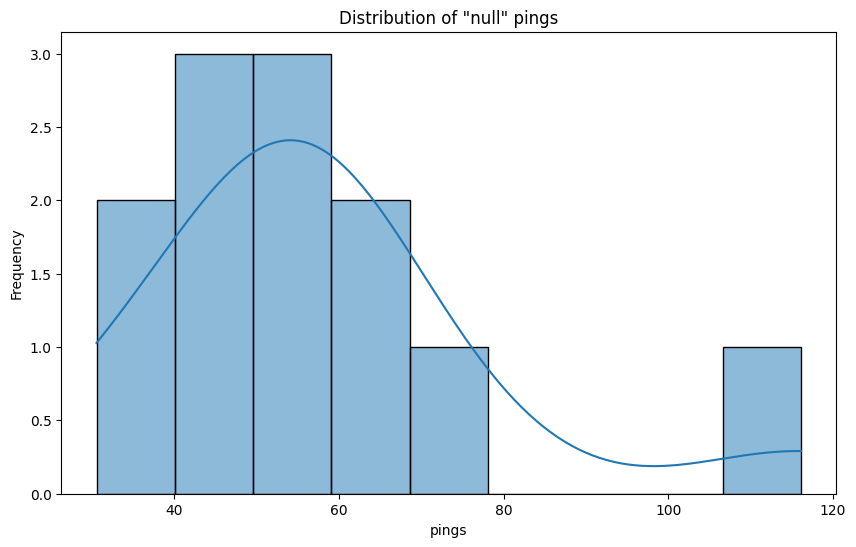

In [ ]:
# 看起來是蠻正常的，就把null捕成'其他'
plt.figure(figsize=(10, 6))
sns.histplot(null_df['total_area_ping'], kde=True)
plt.xlabel('pings')
plt.ylabel('Frequency')
plt.title('Distribution of "null" pings')
plt.show()

## 整體的total_area_ping
* 先看上面處理的如何再決定這邊

In [ ]:
pings = df_clean['total_area_ping']

In [ ]:
pings.describe()

count    806578.000000
mean         42.743463
std          94.039980
min           0.000000
25%          24.610000
50%          34.430000
75%          49.260000
max       29216.550000
Name: total_area_ping, dtype: float64

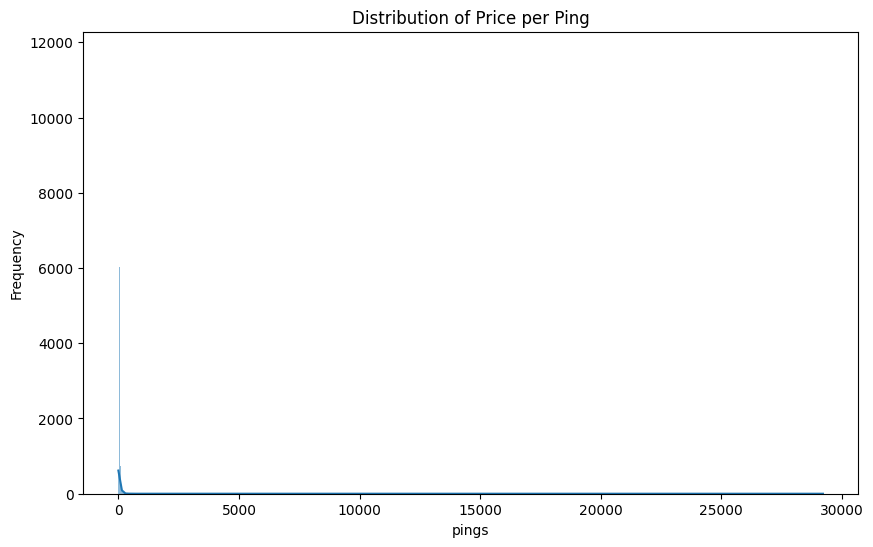

In [ ]:
# 處理前的分佈圖
plt.figure(figsize=(10, 6))
sns.histplot(pings, kde=True)
plt.xlabel('pings')
plt.ylabel('Frequency')
plt.title('Distribution of Price per Ping')
plt.show()

## df_clean實際填值

In [ ]:
df_clean['property_type'].fillna(value='其他', inplace=True)

In [ ]:
non_live_drop_index = df_clean[ (df_clean['property_type'] == '辦公商業大樓') | (df_clean['property_type'] == '農舍') | (df_clean['property_type'] == '廠辦') | (df_clean['property_type'] == '工廠') | (df_clean['property_type'] == '倉庫') ].index

In [ ]:
non_live_drop_index

Index([   138,    139,    173,    302,    473,    474,    602,    605,    740,
         1094,
       ...
       717259, 717273, 717344, 717450, 717456, 717561, 717573, 717574, 717686,
       780979],
      dtype='int64', length=15493)

In [ ]:
store_drop_index = df_clean[ (df_clean['property_type'] == '店面（店舖)') & (df_clean['total_area_ping'] > loose_store_max) ]['total_area_ping'].index

In [ ]:
other_drop_index = df_clean[ (df_clean['property_type'] == '其他')  & (df_clean['total_area_ping'] > other_loose_max) ]['total_area_ping'].index

In [ ]:
all_drop_index = list(non_live_drop_index) + list(store_drop_index) + list(other_drop_index)

In [ ]:
df_after_ping_process = df_clean.drop(all_drop_index, axis=0)

In [ ]:
df_after_ping_process[df_after_ping_process['total_area_ping'] == 16075.180000]['property_type']

225543    住宅大樓(11層含以上有電梯)
Name: property_type, dtype: object

In [ ]:
df_after_ping_process.iloc[225543]

usage_category                                 商
address                大安區信義路四段００２４號#大安區信義路四段２４號
property_type                    住宅大樓(11層含以上有電梯)
community_name                               NaN
main_building_ratio                        94.74
                                 ...            
杜拜輕原油現貨價                                 74.5725
水泥50kg北區台泥                                 169.5
無鉛汽油95                                      30.4
竹節鋼筋_南                                   20400.0
預拌混凝土3000磅台北                              2375.0
Name: 232430, Length: 149, dtype: object

In [ ]:
df_after_ping_process['total_area_ping'].describe()

count    790357.000000
mean         40.480867
std          57.442090
min           0.000000
25%          24.500000
50%          34.130000
75%          48.550000
max       16075.180000
Name: total_area_ping, dtype: float64

KeyboardInterrupt: 

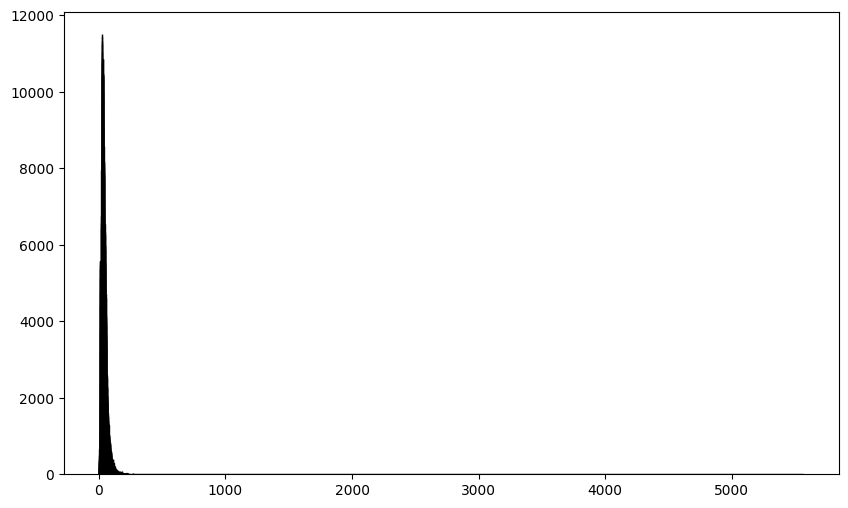

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_after_ping_process['total_area_ping'], kde=True)
plt.xlabel('pings')
plt.ylabel('Frequency')
plt.title('Distribution of Price per Ping')
plt.show()

In [ ]:
df_after_ping_process.info()

In [ ]:
# 全部再濾一次
total_IQR = (df_after_ping_process['total_area_ping'].quantile(0.75)) - (df_after_ping_process['total_area_ping'].quantile(0.25))
total_strict_max = (df_after_ping_process['total_area_ping'].quantile(0.75)) + (3*total_IQR)

In [ ]:
total_strict_max

In [ ]:
len(df_after_ping_process[df_after_ping_process['total_area_ping'] > (total_strict_max)])

In [ ]:
df_after_ping_process[df_after_ping_process['total_area_ping'] < (total_strict_max)]['total_area_ping'].describe()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_after_ping_process[df_after_ping_process['total_area_ping'] < (total_strict_max)]['total_area_ping'], kde=True)
plt.xlabel('pings')
plt.ylabel('Frequency')
plt.title('Distribution of Price per Ping')
plt.show()

In [ ]:
# 先留個 3IQR + 30 =150坪左右
df_after_ping_process = df_after_ping_process[df_after_ping_process['total_area_ping'] < (total_strict_max + 30)]

In [ ]:
df_after_ping_process['total_area_ping'].describe()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_after_ping_process['total_area_ping'], kde=True)
plt.xlabel('pings')
plt.ylabel('Frequency')
plt.title('Distribution of Price per Ping')
plt.show()

## 畸零地 小於多少坪?
* 就先5坪以下 (2000多筆就先濾掉了)

In [ ]:
# 套房(1房(1廳)1衛)

In [ ]:
one_room_df = df_after_ping_process[df_after_ping_process['property_type'] == '套房(1房(1廳)1衛)']

In [ ]:
one_room_df['total_area_ping'].describe()

In [ ]:
all_under_5 = df_after_ping_process[df_after_ping_process['total_area_ping'] < 5 ]

In [ ]:
len(all_under_5)

In [ ]:
type_counts = all_under_5['property_type'].value_counts()

In [ ]:
type_counts

In [ ]:
# 繪製長條圖 # 使用某個類別特徵然後value_counts()就可以畫圖了
plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Counts of Each Type in under 5 ping')
plt.xticks(rotation=0)
plt.show()

In [ ]:
small_ping_drop_index = df_after_ping_process[df_after_ping_process['total_area_ping'] < 5 ].index

In [ ]:
len(small_ping_drop_index)

In [ ]:
df_after_ping_process = df_after_ping_process.drop(small_ping_drop_index, axis=0)

In [ ]:
df_after_ping_process['total_area_ping'].describe()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_after_ping_process['total_area_ping'], kde=True)
plt.xlabel('pings')
plt.ylabel('Frequency')
plt.title('Distribution of pings final version')
plt.show()

# 建立new_per_ping 預測目標
* 跟"年分"
* 跟"區域" 都有關

In [ ]:
per_ping_df = df_after_ping_process.copy()

In [ ]:
per_ping_df['total_area_ping'].describe()

In [ ]:
per_ping_df['new_per_ping'] = (per_ping_df['total_price'] / per_ping_df['total_area_ping']).round(2)

In [ ]:
per_ping_df['new_per_ping'].isnull().sum()

In [ ]:
per_ping_df['new_per_ping'].describe()

In [ ]:
# 3倍標準差
std_per_ping = per_ping_df['new_per_ping'].std()
three_std_max = per_ping_df['new_per_ping'].mean() + (3*std_per_ping)
three_std_max

In [ ]:
# 四分位距
per_ping_price_IQR = per_ping_df['new_per_ping'].quantile(0.75) - per_ping_df['new_per_ping'].quantile(0.25)
strict_max_per_ping_price = per_ping_df['new_per_ping'].quantile(0.75) + (3*per_ping_price_IQR)
strict_max_per_ping_price

In [ ]:
per_ping = per_ping_df['new_per_ping']
# 分佈圖
plt.figure(figsize=(10, 6))
sns.histplot(per_ping_df['new_per_ping'], kde=True)
plt.xlabel('Price per Ping')
plt.ylabel('Frequency')
plt.title('Distribution of Price per Ping')
plt.show()

In [ ]:
# per_ping_df[per_ping_df['new_per_ping'] < strict_max_per_ping_price]
plt.figure(figsize=(10, 6))
sns.histplot(per_ping_df[per_ping_df['new_per_ping'] < 2000000]['new_per_ping'], kde=True)
plt.xlabel('Price per Ping')
plt.ylabel('Frequency')
plt.title('Distribution of Price per Ping')
plt.show()

## 每年每區的new_per_ping分布圖

In [ ]:
per_ping_df['year_month_for_combine'] = pd.to_datetime(per_ping_df['year_month_for_combine'])
per_ping_df['year'] = per_ping_df['year_month_for_combine'].dt.year
per_ping_df['month'] = per_ping_df['year_month_for_combine'].dt.month
years = per_ping_df['year'].unique()
areas = per_ping_df['district'].unique()

In [ ]:
import os
# 每年的分佈圖
# years = per_ping_df['year'].unique()
areas = per_ping_df['district'].unique()

for area in areas:
  district_df = per_ping_df[ per_ping_df['district'] == area ]
  # years = per_ping_df['year'].unique()
  district_df['year_month_for_combine'] = pd.to_datetime(district_df['year_month_for_combine']) # 再確保一次?
  for year in years:
    year_df = district_df[district_df['year_month_for_combine'].dt.year == year]
    y_per_ping = year_df['new_per_ping']
    # 畫圖
    plt.figure(figsize=(10, 6))
    sns.histplot(y_per_ping, kde=True)
    plt.xlabel(f'Price per Ping __{area}__ {year}')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of new per ping __{area}__ {year}')
    plt.show()

## 假設房價逐年增加(以現有趨勢圖確實是如此)
* 那我就取23,24年的3IQR作為最高的上限

In [ ]:
df_2023_4 = per_ping_df[ (per_ping_df['year'] == 2023) | (per_ping_df['year'] == 2024)]

In [ ]:
df_2023_4['new_per_ping'].describe()

In [ ]:
pp_IQR = df_2023_4['new_per_ping'].quantile(0.75) - df_2023_4['new_per_ping'].quantile(0.25)

In [ ]:
strict_IQR_2023_4 = df_2023_4['new_per_ping'].quantile(0.75) + (3*pp_IQR)
three_std_2023_4 = df_2023_4['new_per_ping'].mean() + (3*df_2023_4['new_per_ping'].std())

In [ ]:
strict_IQR_2023_4

In [ ]:
after_new_per_ping_outlier_df = per_ping_df[per_ping_df['new_per_ping'] < strict_IQR_2023_4]

In [ ]:
after_new_per_ping_outlier_df.info(max_cols=152)

# 把2012年前6個月刪除(資料量過少)

In [ ]:
after_new_per_ping_outlier_df

In [ ]:
after_new_per_ping_outlier_df['year_month_for_combine'] = pd.to_datetime(after_new_per_ping_outlier_df['year_month_for_combine'])
after_new_per_ping_outlier_df['year'] = after_new_per_ping_outlier_df['year_month_for_combine'].dt.year
after_new_per_ping_outlier_df['month'] = after_new_per_ping_outlier_df['year_month_for_combine'].dt.month
before_2012_6_index = after_new_per_ping_outlier_df[ (after_new_per_ping_outlier_df['year'] ==2012) & (after_new_per_ping_outlier_df['month'] <= 6) ].index

In [ ]:
after_new_per_ping_outlier_df.drop(before_2012_6_index, axis=0, inplace=True)

In [ ]:
after_new_per_ping_outlier_df.info()

In [ ]:
after_new_per_ping_outlier_df['new_per_ping'].describe()
per_ping = after_new_per_ping_outlier_df['new_per_ping']

# 分佈圖
plt.figure(figsize=(10, 6))
sns.histplot(after_new_per_ping_outlier_df['new_per_ping'], kde=True)
plt.xlabel('Price per Ping')
plt.ylabel('Frequency')
plt.title('Distribution of Price per Ping')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=per_ping, color='blue')
plt.title('ping box')
plt.xlabel('per_ping')
plt.gca().set_facecolor('white')  # 設置背景色為白色

# 顯示圖表
plt.show()

# note有空再清

# 是否有電梯的補值
* property_type 有電梯就是有電梯先補這樣
* 比較麻煩的是套房、店面就看不出有沒有電梯了

In [ ]:
after_new_per_ping_outlier_df['property_type'].fillna(value="其他", inplace=True)
after_new_per_ping_outlier_df['property_type'].isnull().sum()

In [ ]:
after_new_per_ping_outlier_df['elevator_available'].isnull().sum().sum()

In [ ]:
after_new_per_ping_outlier_df[['elevator_available', 'property_type']].value_counts()

In [ ]:
# 先把nan值填100方便後續操作
after_new_per_ping_outlier_df['elevator_available'].fillna(value=100, inplace=True)

In [ ]:
after_new_per_ping_outlier_df[['elevator_available', 'property_type']][after_new_per_ping_outlier_df['elevator_available'] == 1.0].value_counts()
# nan先以100表示，若是100就先給0(表示沒有電梯)
after_new_per_ping_outlier_df['elevator_available'] = np.where(after_new_per_ping_outlier_df['elevator_available'].isin([1,100]), 0, 1)

In [ ]:
after_new_per_ping_outlier_df[['elevator_available', 'property_type']].value_counts()

In [ ]:
after_new_per_ping_outlier_df['elevator_available'].unique()
after_new_per_ping_outlier_df['elevator_available'].isnull().sum()

In [ ]:
# 從property_type得知的有電梯的型態
after_new_per_ping_outlier_df['have_elevator'] = np.where(after_new_per_ping_outlier_df['property_type'].isin(['住宅大樓(11層含以上有電梯)','華廈(10層含以下有電梯)', '辦公商業大樓']), 1, 0)

In [ ]:
after_new_per_ping_outlier_df[['have_elevator', 'property_type']].value_counts()

In [ ]:
# 把兩個欄位相加(都是0,1)，如果重複會等於2就給他改回1
after_new_per_ping_outlier_df['have_elevator_f'] = after_new_per_ping_outlier_df['have_elevator'] + after_new_per_ping_outlier_df['elevator_available']
after_new_per_ping_outlier_df['have_elevator_f'] = np.where(after_new_per_ping_outlier_df['have_elevator_f'].isin([1,2]), 1, 0)
after_new_per_ping_outlier_df['have_elevator_f'].value_counts()

In [ ]:
after_new_per_ping_outlier_df[['have_elevator_f', 'property_type']].value_counts()

In [ ]:
after_new_per_ping_outlier_df['have_elevator_f'].isnull().sum()

# community_name有就給1沒有就0

In [ ]:
after_new_per_ping_outlier_df['community_name'].fillna(value=0, inplace=True)
after_new_per_ping_outlier_df['community_name'].isnull().sum()
after_new_per_ping_outlier_df['community_name'] = np.where(after_new_per_ping_outlier_df['community_name'].isin([0]), 0, 1)
after_new_per_ping_outlier_df['community_name'].unique()

# 看一下比鄰

In [ ]:
near_fac_df = after_new_per_ping_outlier_df.copy() # 目前的主資料表

In [ ]:
############################## 存檔 ##########################################################################################################
# near_fac_df.to_csv('/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/EDA_main_data_version2_0627.csv', encoding='utf-8', index=True)

In [ ]:
near_fac_df.info(max_cols=154)

In [ ]:
near_fac_df_2 = after_new_per_ping_outlier_df.iloc[:,31:106]

In [ ]:
near_fac_df_2.info()

In [ ]:
new_col = [
    'Public_Activity_Space_under_250_m', 'Public_Activity_Space_under_500_m', 'Public_Activity_Space_under_750_m',
    'Interchange_Entrance_under_250_m', 'Interchange_Entrance_under_500_m', 'Interchange_Entrance_under_750_m',
    'MRT_Exit_under_250_m', 'MRT_Exit_under_500_m', 'MRT_Exit_under_750_m',
    'Religious_Site_under_250_m', 'Religious_Site_under_500_m', 'Religious_Site_under_750_m',
    'Fire_Department_under_250_m', 'Fire_Department_under_500_m', 'Fire_Department_under_750_m',
    'Shopping_Area_under_250_m', 'Shopping_Area_under_500_m', 'Shopping_Area_under_750_m',
    'Library_under_250_m', 'Library_under_500_m', 'Library_under_750_m',
    'School_under_250_m', 'School_under_500_m', 'School_under_750_m',
    'Art_Culture_under_250_m', 'Art_Culture_under_500_m', 'Art_Culture_under_750_m',
    'Hospital_under_250_m', 'Hospital_under_500_m', 'Hospital_under_750_m',
    'Gas_Station_under_250_m', 'Gas_Station_under_500_m', 'Gas_Station_under_750_m',
    'Kindergarten_under_250_m', 'Kindergarten_under_500_m', 'Kindergarten_under_750_m',
    'Daycare_Center_under_250_m', 'Daycare_Center_under_500_m', 'Daycare_Center_under_750_m',
    'Court_Prosecutors_Office_under_250_m', 'Court_Prosecutors_Office_under_500_m', 'Court_Prosecutors_Office_under_750_m',
    'Convenience_Store_under_250_m', 'Convenience_Store_under_500_m', 'Convenience_Store_under_750_m',
    'Power_Plant_under_250_m', 'Power_Plant_under_500_m', 'Power_Plant_under_750_m',
    'Cleaning_Unit_under_250_m', 'Cleaning_Unit_under_500_m', 'Cleaning_Unit_under_750_m',
    'Incineration_Plant_under_250_m', 'Incineration_Plant_under_500_m', 'Incineration_Plant_under_750_m',
    'Bank_under_250_m', 'Bank_under_500_m', 'Bank_under_750_m',
    'Funeral_Home_under_250_m', 'Funeral_Home_under_500_m', 'Funeral_Home_under_750_m',
    'Police_Station_under_250_m', 'Police_Station_under_500_m', 'Police_Station_under_750_m',
    'Nursing_Home_under_250_m', 'Nursing_Home_under_500_m', 'Nursing_Home_under_750_m',
    'Clinic_under_250_m', 'Clinic_under_500_m', 'Clinic_under_750_m',
    'Pharmacy_under_250_m', 'Pharmacy_under_500_m', 'Pharmacy_under_750_m',
    'Medical_Facility_under_250_m', 'Medical_Facility_under_500_m', 'Medical_Facility_under_750_m'
]

translation_dict = {
    '公共活動空間': 'Public_Activity_Space',
    '交流道出入口': 'Interchange_Entrance',
    '捷運出口': 'MRT_Exit',
    '宗教場所': 'Religious_Site',
    '消防單位': 'Fire_Department',
    '商圈': 'Shopping_Area',
    '圖書館': 'Library',
    '學校': 'School',
    '藝文': 'Art_Culture',
    '醫院': 'Hospital',
    '加油站': 'Gas_Station',
    '幼兒園': 'Kindergarten',
    '托兒所': 'Daycare_Center',
    '法院_檢察署': 'Court_Prosecutors_Office',
    '便利商店': 'Convenience_Store',
    '發電廠': 'Power_Plant',
    '清潔單位': 'Cleaning_Unit',
    '焚化廠': 'Incineration_Plant',
    '銀行': 'Bank',
    '殯儀館': 'Funeral_Home',
    '警局': 'Police_Station',
    '療養院': 'Nursing_Home',
    '診所': 'Clinic',
    '藥局': 'Pharmacy',
    '醫療設施': 'Medical_Facility'
}

In [ ]:
near_fac_df_2.columns = new_col
near_fac_df_2.columns

## 計算累加欄位

In [ ]:
target_df_near_fac_df = near_fac_df_2.copy() # 並到新的表格比較不會出問題

for index in range(0,73,3): # 每個比鄰總類，切一個df
  tmp_each_fac_df = near_fac_df_2.iloc[:, index:index+3]
  fac_name = tmp_each_fac_df.columns[0].split('under')[0] # 取設施名稱
  target_df_near_fac_df[f'acc_{fac_name}under_500m'] = tmp_each_fac_df.iloc[:,0] + tmp_each_fac_df.iloc[:,1]
  target_df_near_fac_df[f'acc_{fac_name}under_750m'] = tmp_each_fac_df.iloc[:,0] + tmp_each_fac_df.iloc[:,1] + tmp_each_fac_df.iloc[:,2]


In [ ]:
target_df_near_fac_df.info(max_cols=125)

In [ ]:
# 把區間的欄位先丟掉
drop_list = []
for index in range(0,73,3): # 每個比鄰總類，切一個df
  tmp_each_fac_df = near_fac_df_2.iloc[:, index:index+3]
  drop_list.append(tmp_each_fac_df.columns[1])
  drop_list.append(tmp_each_fac_df.columns[2])

len(drop_list)

In [ ]:
target_df_near_fac_df.drop(drop_list, axis=1, inplace=True)

In [ ]:
target_df_near_fac_df.info()

## 低變異過濾(比鄰設施的)，我認為此類變數屬於Ratio Scale(因為是可以比較倍數的* /)

In [ ]:
# 0.9標準差至少接近1，我們的數據至少都是以1為單位計算的
threshold = 0.9
# low_v = target_df_near_fac_df.std()[target_df_near_fac_df.std() < threshold].index.values
print(target_df_near_fac_df.std()[target_df_near_fac_df.std() < threshold].index.values) # 很酷的寫法，用function後照樣可以fancy indexing

In [ ]:
low_v = target_df_near_fac_df.std()[target_df_near_fac_df.std() < threshold]

In [ ]:
# .values可以從pandas.Index >> array
low_v_drop_list = low_v.index.values
target_df_near_fac_df.drop(low_v_drop_list, axis=1, inplace=True)

In [ ]:
target_df_near_fac_df.info()

## 把主表個的低變異欄位刪除

In [ ]:
nn_df = near_fac_df.copy()

In [ ]:
dd_list = []
for i in range(31,106):
  dd_list.append(i)

In [ ]:
# nn_df.info(max_cols=155)
# nn_df.columns[dd_list]這樣的寫法其實就是把column name用出來，所以drop axis=1(col)就是要用column name
nn_df.drop(nn_df.columns[dd_list], axis=1, inplace=True) # 若要用columns的index丟要這樣寫
# near_fac_df = df.iloc[:,31:106]

In [ ]:
final_df = pd.concat([nn_df,target_df_near_fac_df],axis=1)

In [ ]:
final_df.to_csv('/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/EDA_main_data_low_var.csv',encoding='utf-8',index=False)

In [ ]:
final_df['property_type'].isnull().sum()

# 基礎捕值fillna

## main_building_ratio
倉庫、工廠:、其他:、廠辦:、農舍:、辦公商業大樓:、透天厝:
這幾個幾乎全部都是nan
其中[倉庫, 工廠, 農舍, 辦公商業大樓, 透天厝]可以假設是"土地類的"，所以可以給100%
"其他"跟"廠辦"就比較難定義，那我覺得可以補全體的平均值

In [ ]:
fillna_df = final_df.copy()

In [ ]:
fillna_df['property_type'].isnull().sum()

In [ ]:
fillna_df['property_type'].unique()

In [ ]:
fillna_df['main_building_ratio'].isnull().sum()

In [ ]:
# fillna_df[fillna_df['property_type'] == '透天厝']['main_building_ratio'].info()

In [ ]:
fillna_df.loc[fillna_df['property_type'] == '透天厝', 'main_building_ratio'] = 100

# 又一次叫你不要寫迴圈....
# for index, value in enumerate(fillna_df['property_type']):
#   if value ==  '透天厝':
#     fillna_df.loc[index,['main_building_ratio']] = 100

In [ ]:
fillna_df['main_building_ratio'].isnull().sum()

In [ ]:
fillna_df['property_type'].isnull().sum()

In [ ]:
type_p_list = fillna_df['property_type'].unique()
type_p_list

In [ ]:
type_p_list_2 = list(type_p_list)

In [ ]:
# 其他要最後填，先排掉
type_p_list_2.pop(6)

In [ ]:
# 我們可以直接使用 .loc 來改變原本的 DataFrame，然後將平均值指派給那些需要填補的索引處。改寫如下：，今天已經兩次這個問題了....

for type_p in type_p_list_2:
  tmp = fillna_df[fillna_df['property_type'] == type_p ]['main_building_ratio']
  need_fillna_index = tmp[ tmp.isnull() ].index

  # 錯誤示範: 簡單來說只要是切片索引下就不能就用fillna直接改變dataframe
  # fillna_df.loc[need_fillna_index, 'main_building_ratio'].fillna(tmp.mean(), inplace=True)

  # 正確反正我們已經找到特定property_type下na的index了，在原先的data_clean使用loc只需要在指定欄位main_building_ratio，我們就可以直接進行填值(mean)
  mean_value = tmp.mean()
  fillna_df.loc[need_fillna_index, 'main_building_ratio'] = mean_value

In [ ]:
type_p_list = fillna_df['property_type'].unique()
for type_p in type_p_list:
  print(f"{type_p}:")
  tmp = fillna_df[fillna_df['property_type'] == type_p ]['main_building_ratio']
  print(f"{type_p} mean ratio:{tmp.mean()}")
  print(f"{type_p}'s main_building_ratio null ratio is {tmp.isnull().sum()}/{len(tmp)}")
  print('-'*50)

### 建立新表格把剩餘main_building_ratio補一補(就是其他拉)

In [ ]:
tt_df = fillna_df.copy()

In [ ]:
tt_df['main_building_ratio'].fillna(tt_df['main_building_ratio'].mean(), inplace=True)

In [ ]:
# 確認一下
type_p_list = tt_df['property_type'].unique()
for type_p in type_p_list:
  print(f"{type_p}:")
  tmp = tt_df[tt_df['property_type'] == type_p ]['main_building_ratio']
  print(f"{type_p} mean ratio:{tmp.mean()}")
  print(f"{type_p}'s main_building_ratio null ratio is {tmp.isnull().sum()}/{len(tmp)}")
  print('-'*50)

## property_b_l_p_type

In [ ]:
tt_df['property_type'].isnull().sum()

In [ ]:
tt_df.drop(['parking_space_price', 'latitude', 'longitude','note', 'price_per_ping', 'detailed_usage_classification', 'total_price', 'cor', 'elevator_available', 'have_elevator'],axis=1, inplace=True)

In [ ]:
tt_df.info(max_cols=104)

In [ ]:
# 房地(土地+建物)     0
# 房地(土地+建物)+車位   1

tt_df['property_b_l_p_type'] = np.where(tt_df['property_b_l_p_type'].isin(['房地(土地+建物)']), 0, 1)

In [ ]:
tt_df['property_b_l_p_type'].unique()

## 要來填building age 和幾房廳

In [ ]:
age_df = tt_df.copy()

In [ ]:
age_list = age_df['property_type'].unique()

In [ ]:
age_list = age_df['property_type'].unique()
for age_p in age_list:
  tmp = age_df[age_df['property_type'] == age_p ]['building_age']
  need_fillna_index = tmp[ tmp.isnull() ].index

  # 錯誤示範: 簡單來說只要是切片索引下就不能就用fillna直接改變dataframe
  # age_df.loc[need_fillna_index, 'main_building_ratio'].fillna(tmp.mean(), inplace=True)

  # 正確: 反正我們已經找到特定property_type下na的index了，在原先的data_clean使用loc只需要在指定欄位main_building_ratio，我們就可以直接進行填值(mean)
  mean_value = tmp.mean()
  age_df.loc[need_fillna_index, 'building_age'] = mean_value

In [ ]:
age_df['building_age'].isnull().sum()

In [ ]:
print('building_age')
for type_p in age_list:
  print(f"{type_p}:")
  tmp = age_df[age_df['property_type'] == type_p ]['building_age']
  print(f"{type_p} mean:{tmp.mean()}")
  print(f"{type_p}'s building_age null ratio is {tmp.isnull().sum()}/{len(tmp)}")
  print('-'*50)

In [ ]:
age_df.to_csv('/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/EDA_fillna_building_age_ok.csv', encoding='utf-8', index=False) # '/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/xgboost_month_freq_dataset.csv'

## 填幾房幾廳
* 這邊是一個一個填，沒有寫迴圈，要重做的話要注意
* 基本上都已property type為分類依據，去填值

In [ ]:
many_room_df = age_df.copy()

In [ ]:
many_room_df.info(max_cols=104)

In [ ]:
def fillna_with_house_rooms(col_name):
  house_set_list = many_room_df['property_type'].unique()
  for age_p in house_set_list:
    tmp = many_room_df[many_room_df['property_type'] == age_p ][col_name]
    need_fillna_index = tmp[ tmp.isnull() ].index

    # 錯誤示範: 簡單來說只要是切片索引下就不能就用fillna直接改變dataframe
    # many_room_df.loc[need_fillna_index, 'main_building_ratio'].fillna(tmp.mean(), inplace=True)

    # 正確反正我們已經找到特定property_type下na的index了，在原先的data_clean使用loc只需要在指定欄位main_building_ratio，我們就可以直接進行填值(mean)
    mean_value = tmp.mean().round(0)
    many_room_df.loc[need_fillna_index, col_name] = mean_value

  type_p_list = many_room_df['property_type'].unique()
  print('col_name')
  print('='*50)
  for type_p in type_p_list:
    print(f"{type_p}:")
    tmp = many_room_df[many_room_df['property_type'] == type_p ][col_name]
    print(f"{type_p} mean:{tmp.mean()}")
    print(f"{type_p}'s col_name null ratio is {tmp.isnull().sum()}/{len(tmp)}")
    print('-'*50)

In [ ]:
rooms_list = many_room_df.columns[17:23]
for col_name in rooms_list:
  fillna_with_house_rooms(col_name)

In [ ]:
type_p_list = many_room_df['property_type'].unique()
print('transaction_floors')
print('='*50)
for type_p in type_p_list:
  print(f"{type_p}:")
  tmp = many_room_df[many_room_df['property_type'] == type_p ]['transaction_floors']
  print(f"{type_p} mean:{tmp.mean()}")
  print(f"{type_p}'s transaction_floors null ratio is {tmp.isnull().sum()}/{len(tmp)}")
  print('-'*50)

In [ ]:
house_set_list = many_room_df['property_type'].unique()
for age_p in house_set_list:
  tmp = many_room_df[many_room_df['property_type'] == age_p ]['transaction_floors']
  need_fillna_index = tmp[ tmp.isnull() ].index

  # 錯誤示範: 簡單來說只要是切片索引下就不能就用fillna直接改變dataframe
  # many_room_df.loc[need_fillna_index, 'main_building_ratio'].fillna(tmp.mean(), inplace=True)

  # 正確反正我們已經找到特定property_type下na的index了，在原先的data_clean使用loc只需要在指定欄位main_building_ratio，我們就可以直接進行填值(mean)
  mean_value = tmp.mean().round(0)
  many_room_df.loc[need_fillna_index, 'transaction_floors'] = mean_value

In [ ]:
many_room_df.info(max_cols=104)

## usage category

In [ ]:
many_room_df.isnull().sum().sum()

In [ ]:
uu_df = many_room_df.copy()

In [ ]:
uu_df['usage_category'].unique()

In [ ]:
# 把null值跟"6","7"，都改成"其他"
uu_df['usage_category'].fillna(value="其他", inplace=True)

for index, value in enumerate(uu_df['usage_category']):
    if value == "6":
        uu_df['usage_category'].iloc[index] = "其他"
    if value == "7":
        uu_df['usage_category'].iloc[index] = "其他"

In [ ]:
uu_df.isnull().sum().sum()

In [ ]:
uu_df['NA1005'].fillna(method='bfill', inplace=True)

In [ ]:
uu_df.info(max_cols=104)

In [ ]:
uu_df.to_csv('/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/EDA_fillna_ok_not_economic_select.csv', encoding='utf-8', index=False) # '/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/xgboost_month_freq_dataset.csv'

# 經濟指標(初挑)

In [ ]:
eco_df_origin = uu_df.copy()

In [ ]:
eco_df_origin.info(max_cols=104)

In [ ]:
eco_df_eco = eco_df_origin.iloc[:,24:65]

In [ ]:
eco_df_eco.columns

In [ ]:
eco_drop_list = ['EA1101', 'EB0312', 'EB0911',   'EB22', 'EC06', 'EC07',
       'LA07', 'MA1501', 'MB65',    'MC36G', 'MO30',
       'MP101G',
       'NE0812', 'OC08G',
         '倫敦鋁現貨價', '倫敦高級銅極現貨價',
       '巴拿馬型貨櫃運費指數', '杜拜輕原油現貨價', '水泥50kg北區台泥', '無鉛汽油95', '竹節鋼筋_南',
       ]

In [ ]:
eco_df_origin.drop(eco_drop_list, axis=1, inplace=True)

In [ ]:
eco_file_path = '/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/house_index.csv'
eco_df = pd.read_csv(eco_file_path)

In [ ]:
eco_df['date'] = pd.to_datetime(eco_df['date'])
eco_df['year_month_for_combine'] = eco_df['date'].dt.to_period('M')

In [ ]:
eco_df.info()

In [ ]:
eco_df_origin['date'] = pd.to_datetime(eco_df_origin['date'])
eco_df_origin['year_month_for_combine'] = eco_df_origin['date'].dt.to_period('M')

In [ ]:
final_dff = eco_df_origin.merge(eco_df, left_on='year_month_for_combine', right_on='year_month_for_combine', how='inner')

In [ ]:
final_dff.info()

In [ ]:
final_dff.drop(['date_y', 'year', 'month', 'transaction_date', 'date_x'],axis=1, inplace=True)

In [ ]:
final_dff.info()

In [ ]:
another_df = final_dff[final_dff['per_ping_calculation_method'] != '總面積-車位總面積 剩餘面積小於1平方公尺 ,不計算單價']

In [ ]:
another_df.drop('per_ping_calculation_method',axis=1,inplace=True)

In [ ]:
another_df.drop('address',axis=1,inplace=True)

In [ ]:
another_df['property_b_l_p_type']

# 編碼
* 最好先處理下面的usage

In [ ]:
# 會自己把原先欄位drop掉
another_df = pd.get_dummies(another_df, columns=['property_type'], prefix='property_type_')
another_df = pd.get_dummies(another_df, columns=['city'], prefix='city_')
another_df = pd.get_dummies(another_df, columns=['property_b_l_p_type'], prefix='property_b_l_p_type_')
another_df = pd.get_dummies(another_df, columns=['district'], prefix='district_')
another_df = pd.get_dummies(another_df, columns=['usage_category'], prefix='usage_category_')

In [ ]:
another_df.drop(['property_b_l_p_type__0'],axis=1,inplace=True)

In [ ]:
another_df.iloc[:,76:127] = another_df.iloc[:,76:127].astype(int)

In [ ]:
another_df.isnull().sum().sum()

In [ ]:
another_df.info(max_cols=131)

In [ ]:
another_df.to_csv('/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/EDA_main_data_for_xgb_version3.csv', encoding='utf-8', index=False) # '/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/xgboost_month_freq_dataset.csv'

# 補看一下usage

In [ ]:
usage_df = final_dff.copy()

In [ ]:
final_dff.info()

In [ ]:
usage_df['usage_category'].value_counts()

In [ ]:
ee_df1 = usage_df[ (usage_df['usage_category'] != '工')]

In [ ]:
eee_df2 = ee_df1[usage_df['usage_category'] != '農']

In [ ]:
eee_df2['usage_category'].isnull().sum().sum()

In [ ]:
eee_df2 = eee_df2[eee_df2['per_ping_calculation_method'] != '總面積-車位總面積 剩餘面積小於1平方公尺 ,不計算單價']

In [ ]:
eee_df2.drop('per_ping_calculation_method',axis=1,inplace=True)

In [ ]:
eee_df2.drop('address',axis=1,inplace=True)

In [ ]:
# 會自己把原先欄位drop掉
eee_df2 = pd.get_dummies(eee_df2, columns=['property_type'], prefix='property_type_')
eee_df2 = pd.get_dummies(eee_df2, columns=['city'], prefix='city_')
eee_df2 = pd.get_dummies(eee_df2, columns=['property_b_l_p_type'], prefix='property_b_l_p_type_')
eee_df2 = pd.get_dummies(eee_df2, columns=['district'], prefix='district_')
eee_df2 = pd.get_dummies(eee_df2, columns=['usage_category'], prefix='usage_category_')

In [ ]:
eee_df2.info()

In [ ]:
eee_df2['property_b_l_p_type__0']

In [ ]:
eee_df2.drop(['property_b_l_p_type__0'],axis=1,inplace=True)

In [ ]:
eee_df2.info(max_cols=129)

In [ ]:
eee_df2.iloc[:,75:129] = eee_df2.iloc[:,75:129].astype(int)

In [ ]:
eee_df2.info(max_cols=129)

In [ ]:
# eee_df2.to_csv('/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/EDA_main_data_for_xgb_version4_usage_fix.csv', encoding='utf-8', index=False) # '/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/xgboost_month_freq_dataset.csv'